# Reverse Engineering 1D Cellular Automata Rules
#### Author: Fiyinfoluwa Dideoluwa

This project explores Elementary Cellular Automata (ECA) simple 1D systems where each cell evolves over time based on a local 3-cell neighborhood and a deterministic rule (0-255). The goal includes:

1. Simulate and analyze the behavior of all 256 ECA rules.

2. Reverse engineer the rule number from a given CA grid by observing how states change over time.

### Steps

- Creating CA simulations using user-defined or random initial states.

- Measuring the frequency of active cells (1s) and clustering rules based on this behavior.

- Visualizing the spatial-temporal evolution of different rules.

- Implementing a rule inference algorithm that reconstructs the original CA rule from the generated grid, validating its accuracy and robustness across multiple rule types.

In [12]:
# import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

### Step 1: 
Creating CA simulations using user-defined or random initial states.

In [13]:

"""
Given a rule number (0–255), return a dictionary mapping each 3-bit neighborhood
pattern (as string) to its binary outcome according to that rule.
"""
def get_rule_table(rule_number):
    binary_repr = f"{rule_number:08b}"  # convert rule number to 8-bit binary string
    keys = ['111', '110', '101', '100', '011', '010', '001', '000']  # all 3-bit patterns
    return {k: int(b) for k, b in zip(keys, binary_repr)} # map pattern to binary output


In [14]:

"""
    Simulate a 1D cellular automaton (CA) for a given rule number.
    Parameters:
        rule_number: int, the CA rule (0–255)
        grid_size: number of cells per row
        time_steps: number of time steps to simulate
        init_mode: 'random' or 'single' to set initial state
"""
def run_ca(rule_number, grid_size=20, time_steps=10000, init_mode='random'):
    # get corresponding rule table for a given rule number
    rule = get_rule_table(rule_number)
    # create empty grid and initialize with zeros
    grid = np.zeros((time_steps, grid_size), dtype=int)

    # Initialize the first row
    if init_mode == 'single':
        grid[0, grid_size // 2] = 1  # middle cell is 1 (active), others 0
    elif init_mode == 'random':   # cells are randomly 0s and 1s
        grid[0] = np.random.choice([0, 1], size=grid_size)
    
    # Evolve the CA over time
    for t in range(1, time_steps):  # t goes from 1 to time_steps-1 (since row 0 is initialized already).
        for i in range(1, grid_size - 1):  # For each cell i (excluding the boundary cells i.e. first and last cells)
            neighborhood = ''.join(map(str, grid[t-1, i-1:i+2])) #join the 3-bit neighborhood patterns using stride = 1) from the previous grid
            grid[t, i] = rule[neighborhood]  # looks up the next state of the centre of the neighborhood from its rule and stores the new value in the next grid, t.
    return grid



### Step 2:
 Measuring the frequency vector of active cells (1s) and clustering rules based on this behavior.

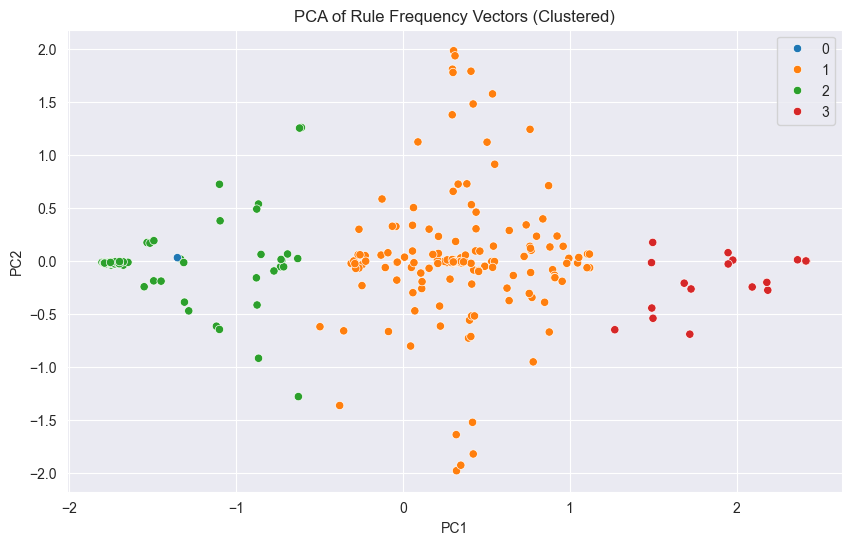


--- Symmetry Check ---
 Found 4788 asymmetric pairs.
Rule 1 and Rule 3 have asymmetric neighbor sets.
Rule 1 and Rule 7 have asymmetric neighbor sets.
Rule 1 and Rule 18 have asymmetric neighbor sets.
Rule 1 and Rule 21 have asymmetric neighbor sets.
Rule 1 and Rule 23 have asymmetric neighbor sets.
Rule 1 and Rule 26 have asymmetric neighbor sets.
Rule 1 and Rule 27 have asymmetric neighbor sets.
Rule 1 and Rule 35 have asymmetric neighbor sets.
Rule 1 and Rule 39 have asymmetric neighbor sets.
Rule 1 and Rule 49 have asymmetric neighbor sets.


In [15]:
"""
Compute frequency vectors of 1s at each position (averaged over time)
for each of the 256 1D cellular automaton rules. Then, cluster these
vectors, visualize them using PCA, and analyze rule similarity using
cosine similarity and symmetry checks.
"""

# Function to compute the frequency vector for a given CA grid
def get_frequency_vector(grid):
    # Average over time (rows), resulting in one value per position (column)
    # This gives a vector of length equal to grid size
    return np.mean(grid, axis=0)

# Initialize a list to store frequency vectors for all 256 rules
frequency_vectors = []

# Iterate over all 256 elementary CA rules (0 to 255)
for rule_num in range(256):
    # Simulate the CA for the current rule
    grid = run_ca(rule_num, grid_size=20, time_steps=200, init_mode='random')
    
    # Compute the frequency vector: average over time for each cell position
    freq_vector = get_frequency_vector(grid)
    
    # Append the result to the list
    frequency_vectors.append(freq_vector)

# Convert the list of vectors into a NumPy array (shape: 256 x grid_size)
frequency_vectors = np.array(frequency_vectors)
# print(frequency_vectors)

# Apply KMeans clustering to the frequency vectors
# Choosing 4 clusters arbitrarily for pattern grouping
kmeans = KMeans(n_clusters=4, random_state=0)
labels = kmeans.fit_predict(frequency_vectors)  # label assigned to each rule

# Reduce frequency vectors to 2D using PCA for visualization
pca = PCA(n_components=2)
reduced = pca.fit_transform(frequency_vectors)

# Plot PCA projection 
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=labels, palette='tab10')
plt.title("PCA of Rule Frequency Vectors (Clustered)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


"""
    Given a matrix of vectors, compute cosine similarity neighbors between all pairs,
    and identify neighbors (rules) whose similarity exceeds a threshold.
"""
def find_neighbors(vectors, threshold=0.98):
    
    similarities = cosine_similarity(vectors)  # 256x256 matrix
    neighbors = {}

    for i in range(len(similarities)):
        # Find indices of rules similar to rule i, excluding self
        neighbors[i] = set(np.where(similarities[i] >= threshold)[0]) - {i}
    
    return neighbors


"""
    Check if similarity-based neighbor sets are symmetric.
    That is, if rule j is close to rule i, then:
    {i} U neighbors[i] == {j} U neighbors[j]
    """
def check_symmetric_relations(neighbors):
    symmetric = True
    asym_pairs = []

    for i, neigh_i in neighbors.items():
        for j in neigh_i:
            # Include the rule itself in its neighborhood set
            set_i = neigh_i | {i}
            set_j = neighbors[j] | {j}

            # Compare sets for symmetry
            if set_i != set_j:
                symmetric = False
                asym_pairs.append((i, j))  # record asymmetric pair
    
    return symmetric, asym_pairs

# Run Analysis
neighbors = find_neighbors(frequency_vectors, threshold=0.98)
symmetric, asym_pairs = check_symmetric_relations(neighbors)

# Output Results
print("\n--- Symmetry Check ---")

if symmetric:
    print(" All neighbor sets are symmetric.")
else:
    print(f" Found {len(asym_pairs)} asymmetric pairs.")
    for i, j in asym_pairs[:10]:  # display a few asymmetric examples
        print(f"Rule {i} and Rule {j} have asymmetric neighbor sets.")
        
# plot to visualize potential threshold        
#sim_scores = cosine_similarity(frequency_vectors).flatten()
#plt.hist(sim_scores, bins=100)
#plt.title("Distribution of Cosine Similarities")



### Step 3: 
Visualizing the spatial-temporal evolution of different rules.

Rule 0 — Frequency Vector: [0.    0.005 0.005 0.005 0.   ]...


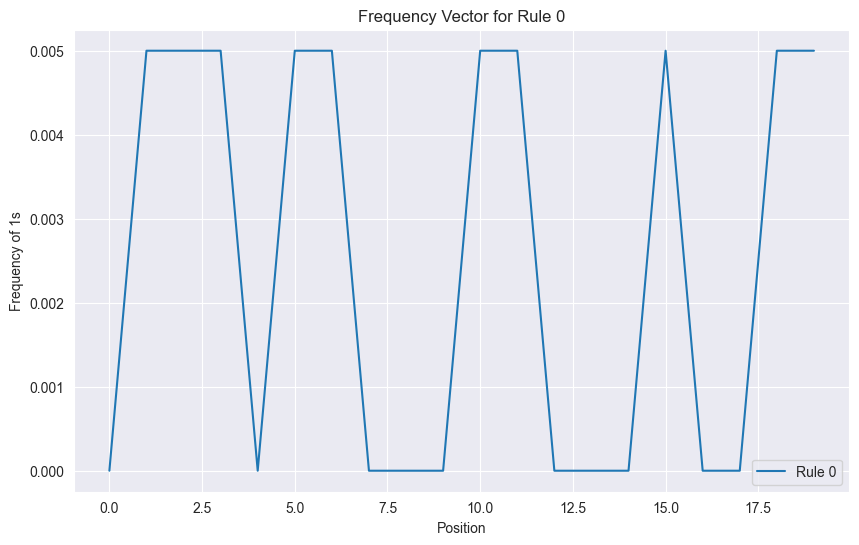

Rule 90 — Frequency Vector: [0.005 0.51  0.515 0.54  0.515]...


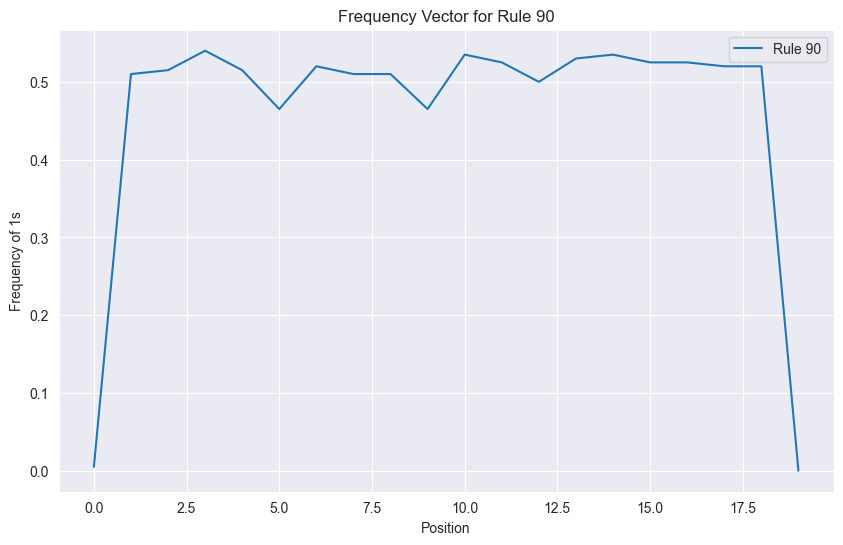

Rule 30 — Frequency Vector: [0.    0.985 0.01  0.99  0.02 ]...


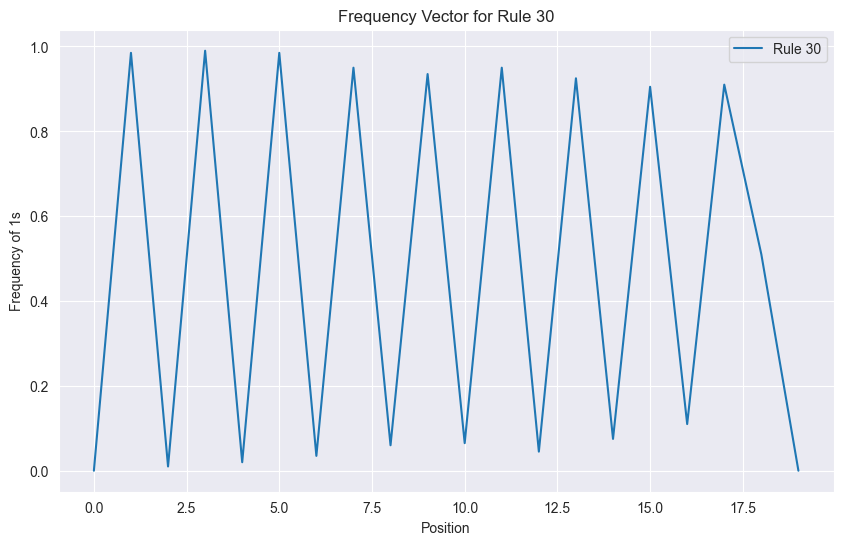

In [16]:
# Visualize Frequency Vectors for Specific Rules
def plot_frequency_vector(rule_num, frequency_vector):
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(frequency_vector)), frequency_vector, label=f"Rule {rule_num}")
    plt.title(f"Frequency Vector for Rule {rule_num}")
    plt.xlabel("Position")
    plt.ylabel("Frequency of 1s")
    plt.grid(True)
    plt.legend()
    plt.show()

# Key example rules to show contrast in frequency vectors
example_rules = [0, 90, 30]

for rule in example_rules:
    grid = run_ca(rule, grid_size=20, time_steps=200, init_mode='random')
    freq_vector = np.mean(grid, axis=0)  # frequency vector across all iterations for each position
    print(f"Rule {rule} — Frequency Vector: {freq_vector[:5]}...")  # printing part of the vector for brevity
    plot_frequency_vector(rule, freq_vector)


### Step 4 : 
Implementing a rule inference algorithm that reconstructs the original CA rule from the generated grid, validating its accuracy and robustness across multiple rule types.

In [17]:

"""
    Infer the rule number used to generate a CA grid.
    Assumes elementary CA (1D, 3-cell neighborhood).
    """
def infer_rule_from_grid(grid):
    rule_dict = {}  # Initialize dictionary to store inferred transitions
    rows, cols = grid.shape

    for t in range(1, rows):    # Iterate over time steps
        for i in range(1, cols - 1):  # Skip boundary cells
            neighborhood = ''.join(str(bit) for bit in grid[t - 1, i - 1:i + 2])
            output = grid[t, i]   # Observed next state

            # Check for consistency
            if neighborhood in rule_dict:
                if rule_dict[neighborhood] != output:
                    raise ValueError(f"Inconsistent output for neighborhood {neighborhood}")
            else:
                rule_dict[neighborhood] = output   # Record transition

    # Ensure all possible neighborhoods are accounted for
    required_keys = ['111', '110', '101', '100', '011', '010', '001', '000']
    if not all(k in rule_dict for k in required_keys):
        missing = [k for k in required_keys if k not in rule_dict]
        raise ValueError(f"Missing patterns in data: {missing}")

    # Convert inferred rule back to integer
    binary_string = ''.join(str(rule_dict[k]) for k in required_keys)
    rule_number = int(binary_string, 2)
    return rule_number


# Test Reverse Engineering
original_rule = 50
grid = run_ca(original_rule)  # run ca for a specific rule number
# infer the rule from the grid generated from rule 30 'Run CA'
inferred_rule = infer_rule_from_grid(grid)

print("\n--- Single Rule Inference Test ---")
print(f"Original Rule: {original_rule}")
print(f"Inferred Rule: {inferred_rule}")
assert inferred_rule == original_rule, "Rule inference failed!"  # check if the original rule equals inferred rule.



--- Single Rule Inference Test ---
Original Rule: 50
Inferred Rule: 50


In [18]:

# step 6:Test Reverse Engineering Robustness on Multiple Rules
"""
    Run reverse inference for a set of rule numbers and print result.
    """
def test_reverse_engineering_robustness(rules_to_test, grid_size=20, time_steps=10000):
    print("\n--- Reverse Engineering Robustness Test ---")
    for rule in rules_to_test:
        grid = run_ca(rule, grid_size=grid_size, time_steps=time_steps, init_mode='single')
        try:
            inferred = infer_rule_from_grid(grid)
            result = "PASS" if rule == inferred else "FAIL"
            print(f"Rule {rule:3d} → Inferred: {inferred:3d} — {result}")
        except Exception as e:
            print(f"Rule {rule:3d} → Error: {e}")

# Test with a diverse set of CA rules
test_rules = [0, 15, 18, 30, 45, 60, 90, 105, 110, 126, 150, 184]
test_reverse_engineering_robustness(test_rules)



--- Reverse Engineering Robustness Test ---
Rule   0 → Error: Missing patterns in data: ['111', '110', '101', '011']
Rule  15 → Inferred:  15 — PASS
Rule  18 → Error: Missing patterns in data: ['111', '110', '011']
Rule  30 → Inferred:  30 — PASS
Rule  45 → Inferred:  45 — PASS
Rule  60 → Inferred:  60 — PASS
Rule  90 → Error: Missing patterns in data: ['111', '110', '011']
Rule 105 → Inferred: 105 — PASS
Rule 110 → Inferred: 110 — PASS
Rule 126 → Inferred: 126 — PASS
Rule 150 → Inferred: 150 — PASS
Rule 184 → Error: Missing patterns in data: ['111', '110', '101', '011']
